In [ ]:
# !pip install keras
# !pip install resampy
!pip uninstall -y librosa resampy
!pip install librosa resampy

Found existing installation: librosa 0.10.2.post1
Uninstalling librosa-0.10.2.post1:
  Successfully uninstalled librosa-0.10.2.post1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.1 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
import os
import math
import wave
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import tensorflow as tf
import matplotlib.pyplot as plt

import keras

# from keras.utils import np_utils
from keras.utils import to_categorical

from tensorflow.keras.layers import Embedding,LSTM,GRU,Dense,MaxPooling1D,Dropout
from tensorflow.keras.layers import LeakyReLU,ReLU,Flatten,concatenate,Bidirectional,TimeDistributed
from tensorflow.keras.layers import add,Conv1D,SeparableConv1D, GlobalMaxPooling2D,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv2D,Input,Activation,BatchNormalization,MaxPooling2D
from tensorflow.keras.models import Sequential

# from keras.layers.merge import concatenate
from tensorflow.keras.layers import concatenate

from tensorflow.keras.models import Model,load_model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet201




from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [ ]:
!pip install -q kaggle

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database
!kaggle datasets download -d monkeypox2022/audio-test

Dataset URL: https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database
License(s): unknown
 99% 3.67G/3.69G [00:44<00:00, 94.6MB/s]
100% 3.69G/3.69G [00:44<00:00, 88.4MB/s]
Dataset URL: https://www.kaggle.com/datasets/monkeypox2022/audio-test
License(s): unknown
  0% 0.00/1.07M [00:00<?, ?B/s]
100% 1.07M/1.07M [00:00<00:00, 117MB/s]


In [ ]:
!kaggle kernels output monkeypox2022/respiratory-rate-classification -p /path/to/dest

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 398, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /content. Or use the environment method.


In [ ]:
!chmod 600 /content/kaggle.json

chmod: cannot access '/content/kaggle.json': No such file or directory


In [ ]:
!unzip respiratory-sound-database.zip
!unzip audio-test.zip

Archive:  respiratory-sound-database.zip
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.wav  
  inflating: Respiratory_Sound_

In [ ]:
os.listdir('./respiratory_sound_database')
df_no_diagnosis = pd.read_csv('./demographic_info.txt', names =
                 ['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                 delimiter = ' ')

diagnosis = pd.read_csv('./respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv', names = ['Patient number', 'Diagnosis'])

In [ ]:
df =  df_no_diagnosis.join(diagnosis.set_index('Patient number'), on = 'Patient number', how = 'left')
df['Diagnosis'].value_counts()

Diagnosis
COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: count, dtype: int64

In [ ]:
root = './respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/'

filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]

#Read Respiratory Cycle Data

In [ ]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [ ]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

my_index = pd.Series(list(rec_annotations_dict.keys()))

#Get Respiratiory Cycle Length and Diagnosis


In [ ]:
res_rate_list = []
for i in range (920):
    cycle_df = pd.DataFrame( list(rec_annotations_dict.values())[i],columns=['Start', 'End' ,'cycle length'])
    cycle_df['cycle length'] = cycle_df['End']-cycle_df['Start']
    average = cycle_df[["Start","End","cycle length"]].mean(axis=0)
    df = pd.DataFrame(average).T
    res_rate_list.append(df)

In [ ]:
res_rate_df = pd.concat(res_rate_list,ignore_index =True)
res_rate_df['filename']= my_index.values
res_rate_df['filename']= res_rate_df['filename'].str[:3]
res_rate_df.sort_values(by=['filename'])

,Start,End,cycle length,filename
742,8.639333,10.300000,1.660667,101
215,9.365636,11.174727,1.809091,101
633,9.807231,11.322615,1.515385,102
405,8.778667,12.047833,3.269167,103
553,6.726769,9.232214,2.505446,104
...,...,...,...,...
136,9.380857,12.227714,2.846857,224
326,9.587714,11.012214,1.424500,225
545,8.444400,10.438600,1.994200,226
264,9.648818,11.461818,1.813000,226


In [ ]:
# Respiratory cycle = Cycle length // 60 seconds
avg = res_rate_df.groupby('filename').mean()
avg['respiratory rate'] = 60 // avg['cycle length']

# Normal Respiratory Rate (12-25) cycle/min
avg['diagnosis'] = 'Normal'
avg['diagnosis'][(avg['respiratory rate'] > 25 )] = "High"
avg

<ipython-input-18-448c5b2db313>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg['diagnosis'][(avg['respiratory rate'] > 25 )] = "High"


,Start,End,cycle length,respiratory rate,diagnosis
filename,,,,,
101,9.002485,10.737364,1.734879,34.0,High
102,9.807231,11.322615,1.515385,39.0,High
103,8.778667,12.047833,3.269167,18.0,Normal
104,8.795221,11.078845,2.283624,26.0,High
105,9.198375,11.682250,2.483875,24.0,Normal
...,...,...,...,...,...
222,35.535680,40.488657,4.952977,12.0,Normal
223,15.320182,18.412637,3.092455,19.0,Normal
224,9.680714,12.529643,2.848929,21.0,Normal


<ipython-input-19-ab4e346fb422>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=avg.diagnosis, palette=['purple', 'green'])


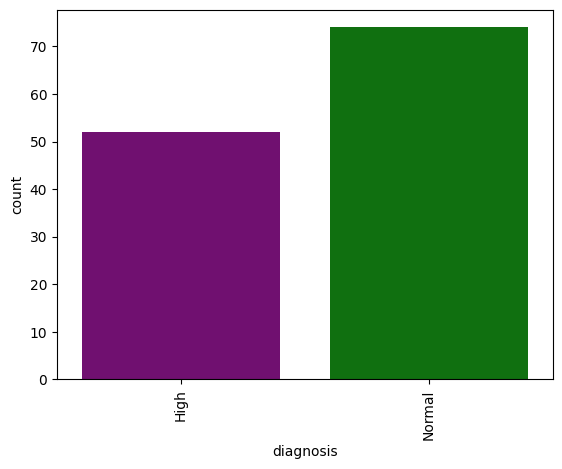

In [ ]:
sns.countplot(x=avg.diagnosis, palette=['purple', 'green'])
my_plt = plt.xticks(rotation=90)
plt.show()

In [ ]:
avg.diagnosis.to_csv('respiratory_rate.csv')

#Data Augmentation

In [ ]:
audio_data = './Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

In [ ]:
rr_diagnosis_df = pd.read_csv('./respiratory_rate.csv', names=['patient_id', 'disease'],header=0)
rr_diagnosis_df.head(4)

,patient_id,disease
0,101,High
1,102,High
2,103,Normal
3,104,High


In [ ]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [ ]:
def mfcc_feature_exteraction_rr(dir_):
    X_=[]
    y_=[]
    COPD=[]
    copd_count=0
    data = rr_diagnosis_df
    features = 50
    for soundDir in (os.listdir(dir_)):
        if soundDir[-3:]=='wav':

            label = list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0]

            if (label == 'Normal'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

            if (label != 'Normal'):
                data_x, sampling_rate = librosa.load(dir_+soundDir,res_type='kaiser_fast')
                mfccs = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs)
                y_.append(list(data[data['patient_id']==int(soundDir[:3])]['disease'])[0])

                data_shift = shift(data_x,1600)
                mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_shift)
                y_.append(label)

                data_noise = add_noise(data_x,0.005)
                mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T,axis = 0)
                X_.append(mfccs_noise)
                y_.append(label)


    X_data = np.array(X_)
    y_data = np.array(y_)



    return X_data ,y_data

In [ ]:
res_data, res_y = mfcc_feature_exteraction_rr(audio_data)

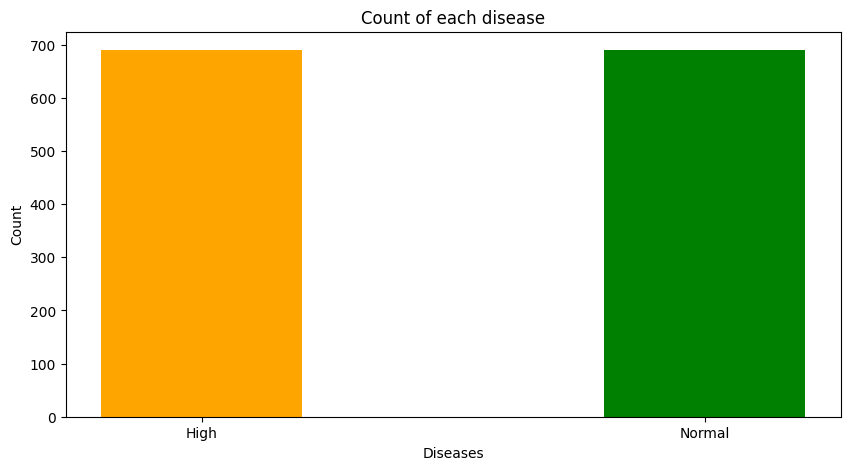

{'High': 690, 'Normal': 690}


In [ ]:
unique, counts = np.unique(res_y, return_counts=True)
data_count = dict(zip(unique, counts))

data = data_count

courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color =['orange','green','blue','red','yellow','black'],
        width = 0.4)

plt.xlabel("Diseases")
plt.ylabel("Count")
plt.title("Count of each disease")
plt.show()

print (data_count)

In [ ]:
res_y_data_encode = res_y.reshape(1380,1)
res_y_data_encode = np.where(res_y_data_encode == 'Normal',np.array([1,0]).reshape(1,2) , res_y_data_encode)
res_y_data_encode = np.where(res_y_data_encode == 'High',np.array([0,1]).reshape(1,2) , res_y_data_encode)

res_lables = res_y_data_encode.astype('float64')

In [ ]:
res_features = np.array(res_data)
res_lables = np.array(res_lables)

res_features.shape , res_lables.shape

((1380, 50), (1380, 2))

#Data Split

In [ ]:
x_train, x_val, y_train, y_val  = train_test_split(res_features,res_lables, test_size=0.175, random_state=10)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.075, random_state=10)


print (x_train.shape, x_val.shape, x_test.shape)
print (y_train.shape, y_val.shape, y_test.shape)

(1052, 50) (242, 50) (86, 50)
(1052, 2) (242, 2) (86, 2)


#LSTM Model

In [ ]:
x_train_lstm = np.expand_dims(x_train,axis=2)
x_val_lstm = np.expand_dims(x_val,axis=2)
x_test_lstm = np.expand_dims(x_test,axis=2)

#Build Model

In [ ]:
model = Sequential()

model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())


model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(2, activation='softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 26, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 26, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 13, 1024)          0         
 g1D)                                                            
                                                        

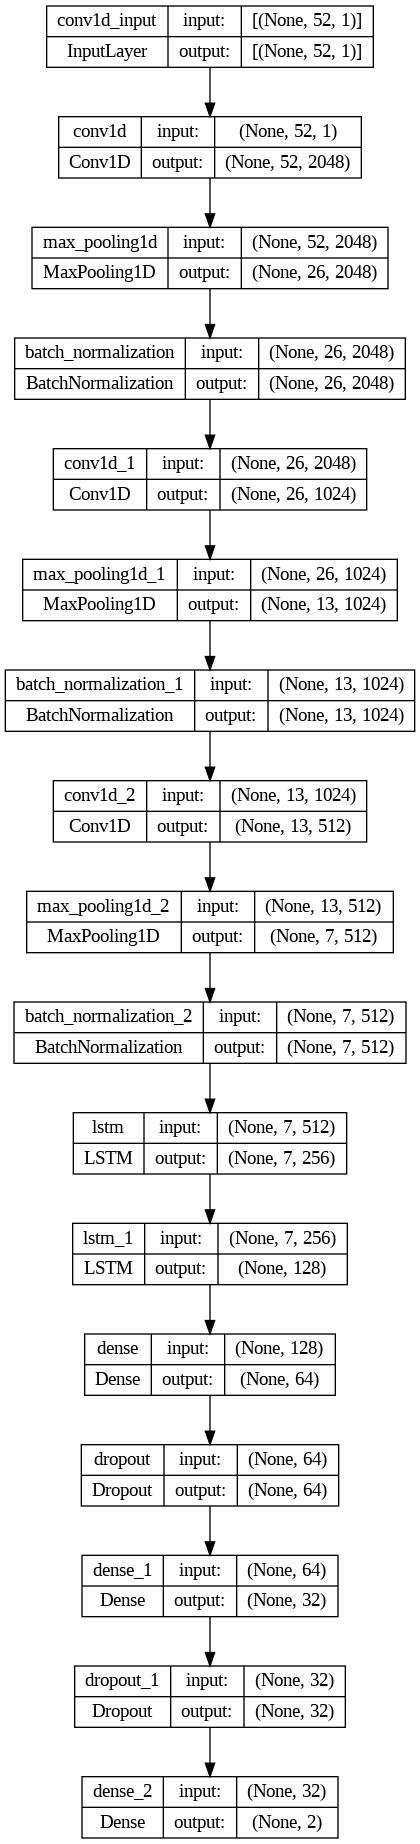

In [ ]:
tf.keras.utils.plot_model(model, "net.png", show_shapes=True)

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


In [ ]:
PATH = "./rr_LSTM_CNN_1.h5"

cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint(PATH,save_best_only=True)]

#Train Model

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Pad sequences to match the expected length of 52
x_train_padded = pad_sequences(x_train_lstm, maxlen=52, dtype='float32')
x_val_padded = pad_sequences(x_val_lstm, maxlen=52, dtype='float32')

# Now, the shape of x_train_padded and x_val_padded will be (number_of_samples, 52, 1)

# Ensure y_train and y_val are properly formatted

# Then, you can proceed with training
history = model.fit(x_train_padded, y_train, batch_size=16, epochs=250, validation_data=(x_val_padded, y_val), callbacks=cb)


Epoch 1/250
66/66 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.5580

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 116s 2s/step - loss: 0.6830 - accuracy: 0.5580 - val_loss: 0.6821 - val_accuracy: 0.5248
Epoch 2/250
66/66 [==============================] - 105s 2s/step - loss: 0.6245 - accuracy: 0.6540 - val_loss: 0.6650 - val_accuracy: 0.5702
Epoch 3/250
66/66 [==============================] - 106s 2s/step - loss: 0.6085 - accuracy: 0.6464 - val_loss: 0.6501 - val_accuracy: 0.5909
Epoch 4/250
66/66 [==============================] - 114s 2s/step - loss: 0.5981 - accuracy: 0.6616 - val_loss: 0.6268 - val_accuracy: 0.6364
Epoch 5/250
66/66 [==============================] - 107s 2s/step - loss: 0.5611 - accuracy: 0.6977 - val_loss: 0.6101 - val_accuracy: 0.7273
Epoch 6/250
66/66 [==============================] - 104s 2s/step - loss: 0.5610 - accuracy: 0.7072 - val_loss: 0.5520 - val_accuracy: 0.7107
Epoch 7/250
66/66 [==============================] - 110s 2s/step - loss: 0.5434 - accuracy: 0.6958 - val_loss: 0.5168 - val_accuracy: 0.7521
Epoch 8/250
66/66 

#Evaluate Model

In [ ]:
model.evaluate(x_val_lstm, y_val)

8/8 [==============================] - 3s 277ms/step - loss: 3.3359 - accuracy: 0.4959


[3.3359262943267822, 0.4958677589893341]

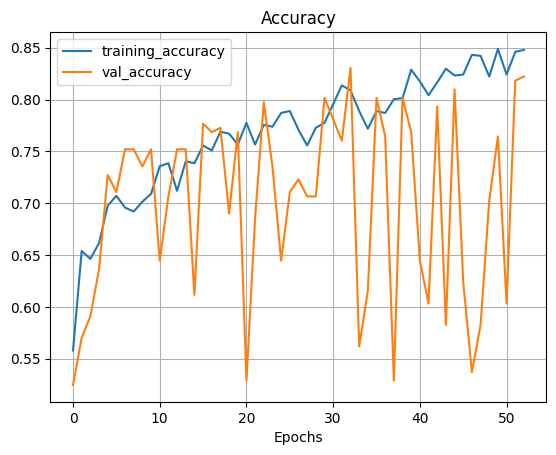

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
#   plt.plot(epochs, loss, label='training_loss')
#   plt.plot(epochs, val_loss, label='val_loss')
#   plt.title('Loss')
#   plt.xlabel('Epochs')
#   plt.legend()
#   plt.grid()


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history)

#Result

3/3 [==============================] - 2s 292ms/step


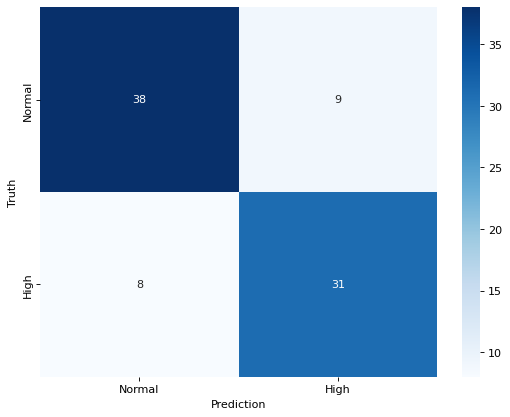

In [ ]:
classes = ["Normal", "High"]

x_test_padded = pad_sequences(x_test_lstm, maxlen=52, dtype='float32')

preds = model.predict(x_test_padded)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.83      0.81      0.82        47
        High       0.78      0.79      0.78        39

    accuracy                           0.80        86
   macro avg       0.80      0.80      0.80        86
weighted avg       0.80      0.80      0.80        86



#Prediction

In [ ]:
def respiratory_rate_prediction(audio_path):

    classes = ["Normal", "High"]

    #load aduio with 22050 Hz sampling rate
    data_x, sampling_rate = librosa.load(audio_path)

    #extract feature using mfcc (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T,axis = 0)

    features = features.reshape(1,50)

    #get the prediction and the confidence
    test_pred = model.predict(np.expand_dims(features, axis = 2))
    classpreds = classes[np.argmax(test_pred, axis=1)[0]]
    confidence = test_pred.T[test_pred.mean(axis=0).argmax()].mean()

    print (classpreds, confidence)

In [ ]:
respiratory_rate_prediction('./74.wav')

1/1 [==============================] - 1s 922ms/step
High 0.97502637


#GRU Model

In [ ]:
x_train_gru = np.expand_dims(x_train,axis=1)
x_val_gru = np.expand_dims(x_val,axis=1)
x_test_gru = np.expand_dims(x_test,axis=1)

y_train_gru = np.expand_dims(y_train,axis=1)
y_val_gru = np.expand_dims(y_val,axis=1)
y_test_gru = np.expand_dims(y_test,axis=1)

#Build Model

In [ ]:
Input_Sample = Input(shape=(1,50))

model_conv = Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu')(Input_Sample)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_conv = Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu')(model_conv)
model_conv = MaxPooling1D(pool_size=2, strides = 2, padding = 'same')(model_conv)
model_conv = BatchNormalization()(model_conv)

model_2_1 = GRU(32,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_2 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_2_1)

model_3 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_conv)
model_3 = GRU(128,return_sequences=True, activation='tanh',go_backwards=True)(model_3)

model_add_1 = add([model_3,model_2])

model_5 = GRU(128,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_5 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_5)

model_6 = GRU(64,return_sequences=True,activation='tanh',go_backwards=True)(model_add_1)
model_6 = GRU(32,return_sequences=True, activation='tanh',go_backwards=True)(model_6)

model_add_2 = add([model_5,model_6,model_2_1])


model_7 = Dense(32, activation=None)(model_add_2)
model_7 = LeakyReLU()(model_7)
model_7 = Dropout(0.2)(model_7)
model_7 = Dense(128, activation=None)(model_7)
model_7 = LeakyReLU()(model_7)

model_9 = Dense(64, activation=None)(model_add_2)
model_9 = LeakyReLU()(model_9)
model_9 = Dropout(0.2)(model_9)
model_9 = Dense(128, activation=None)(model_9)
model_9 = LeakyReLU()(model_9)

model_add_3 = add([model_7,model_9])

model_10 = Dense(64, activation=None)(model_add_3)
model_10 = LeakyReLU()(model_10)
model_10 = Dropout(0.5)(model_10)

model_10 = Dense(32, activation=None)(model_10)
model_10 = LeakyReLU()(model_10)
model_10 = Dropout(0.3)(model_10)

model_10 = Dense(2, activation="softmax")(model_10)

GRU_model = Model(inputs=Input_Sample, outputs = model_10)

GRU_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 50)]              0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 1, 256)               64256     ['input_1[0][0]']             
                                                                                                  
 max_pooling1d_3 (MaxPoolin  (None, 1, 256)               0         ['conv1d_3[0][0]']            
 g1D)                                                                                             
                                                                                                  
 batch_normalization_3 (Bat  (None, 1, 256)               1024      ['max_pooling1d_3[0][0]'] 

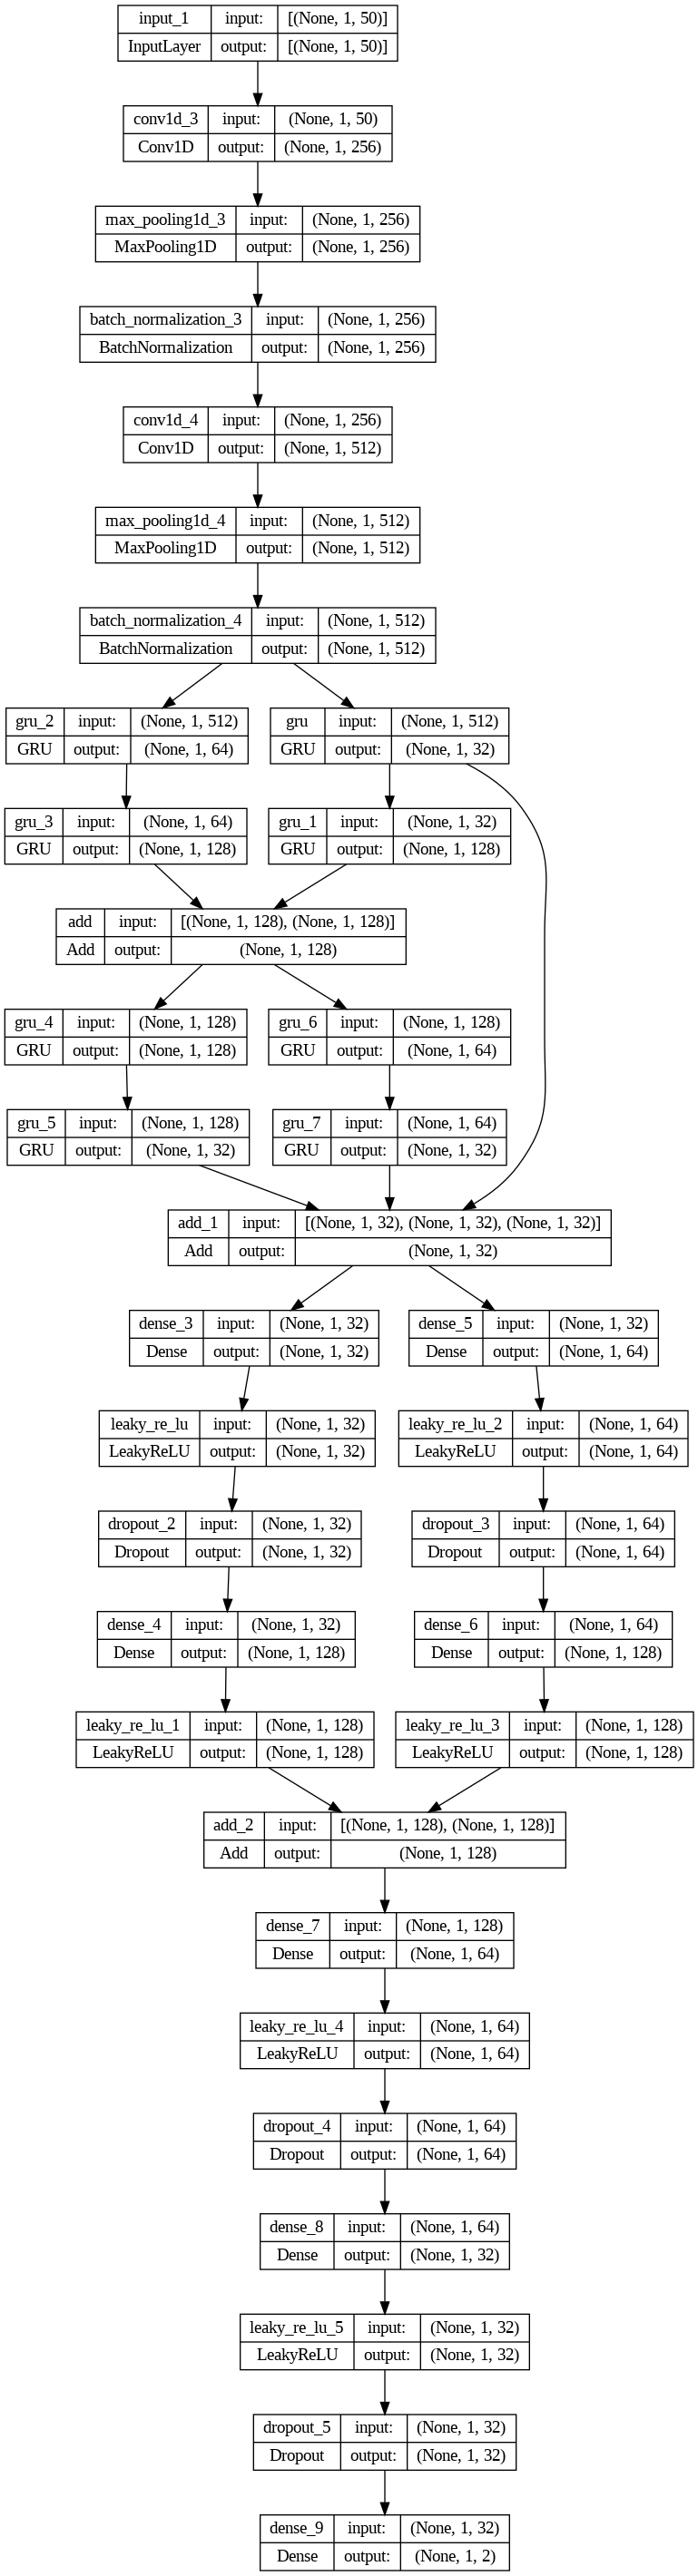

In [ ]:
tf.keras.utils.plot_model(GRU_model, "GRU.png", show_shapes=True)

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
GRU_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [ ]:
cb = [EarlyStopping(patience=20,monitor='val_accuracy',mode='max',restore_best_weights=True),
      ModelCheckpoint("./rr_GRU_CNN_1.h5",save_best_only=True)]

#Train Model

In [ ]:
history = GRU_model.fit(x_train_gru, y_train_gru, batch_size=16, epochs=250, validation_data=(x_val_gru, y_val_gru),callbacks = cb )

Epoch 1/250
66/66 [==============================] - 25s 90ms/step - loss: 0.6404 - accuracy: 0.5998 - val_loss: 0.6791 - val_accuracy: 0.5455
Epoch 2/250
 1/66 [..............................] - ETA: 2s - loss: 0.6818 - accuracy: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


66/66 [==============================] - 4s 62ms/step - loss: 0.5665 - accuracy: 0.6920 - val_loss: 0.6301 - val_accuracy: 0.7479
Epoch 3/250
66/66 [==============================] - 3s 39ms/step - loss: 0.5214 - accuracy: 0.7462 - val_loss: 0.5422 - val_accuracy: 0.7686
Epoch 4/250
66/66 [==============================] - 3s 41ms/step - loss: 0.4950 - accuracy: 0.7529 - val_loss: 0.4823 - val_accuracy: 0.7562
Epoch 5/250
66/66 [==============================] - 3s 41ms/step - loss: 0.4667 - accuracy: 0.7890 - val_loss: 0.4549 - val_accuracy: 0.8017
Epoch 6/250
66/66 [==============================] - 3s 47ms/step - loss: 0.4416 - accuracy: 0.7966 - val_loss: 0.4295 - val_accuracy: 0.8017
Epoch 7/250
66/66 [==============================] - 4s 58ms/step - loss: 0.4201 - accuracy: 0.8165 - val_loss: 0.4102 - val_accuracy: 0.8306
Epoch 8/250
66/66 [==============================] - 3s 39ms/step - loss: 0.3827 - accuracy: 0.8413 - val_loss: 0.4721 - val_accuracy: 0.7769
Epoch 9/250
66/66 

#Evaluate Model

8/8 [==============================] - 0s 6ms/step - loss: 0.3894 - accuracy: 0.9298


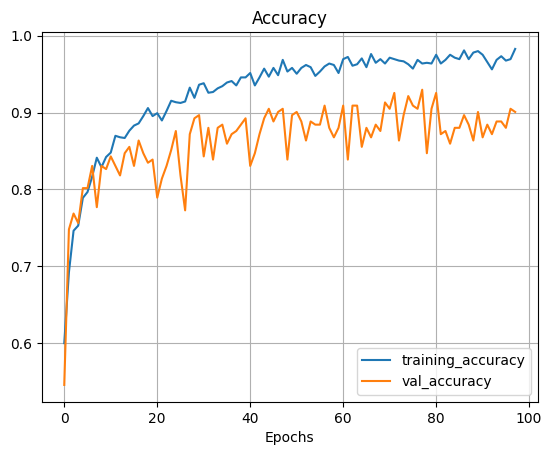

In [ ]:
GRU_model.evaluate(x_val_gru, y_val_gru)
plot_loss_curves(history)

#Results

3/3 [==============================] - 3s 7ms/step


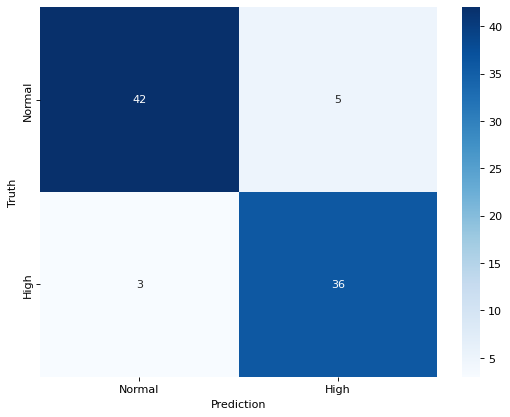

In [ ]:
classes = ["Normal", "High"]

preds = GRU_model.predict(x_test_gru)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.93      0.89      0.91        47
        High       0.88      0.92      0.90        39

    accuracy                           0.91        86
   macro avg       0.91      0.91      0.91        86
weighted avg       0.91      0.91      0.91        86



#Prediction

In [ ]:
def respiratory_rate_prediction_gru(audio_path):

    classes = ["Normal", "High"]

    #load aduio with 22050 Hz sampling rate
    data_x, sampling_rate = librosa.load(audio_path)

    #extract feature using mfcc (50 features)
    features = np.mean(librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=50).T,axis = 0)

    features = features.reshape(1,50)

    #get the prediction and the confidence
    test_pred = GRU_model.predict(np.expand_dims(features, axis = 1))
    classpreds = classes[np.argmax(test_pred[0], axis=1)[0]]
    confidence = test_pred.T[test_pred[0].mean(axis=0).argmax()].mean()

    print (classpreds, confidence)

In [ ]:
respiratory_rate_prediction_gru('./74.wav')

1/1 [==============================] - 0s 33ms/step
High 0.9994179
